<a href="https://colab.research.google.com/github/meichenfang/Poisson-regression/blob/main/Demos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EM_functions.py

In [16]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jun 16 21:20:50 2022

@author: Meichen Fang
"""

import numpy as np
from tqdm import tqdm
from multiprocessing import Pool
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# global parameters: upper and lower limits for numerical stability
eps = 1e-6
omega = -1e6

def get_Y(theta, t, tau):
    # theta: p*(K+4)
    # t: len m
    # tau: len K+1
    # return m * p * 2
    p = len(theta)
    K = len(tau)-1 # number of states
    if np.shape(theta)[1]!=K+4:
      raise TypeError("wrong parameters lengths")
    a = theta[:,0:K]
    beta = theta[:,-2]
    gamma = theta[:,-1]

    y1_0 = theta[:,-4]
    y2_0 = theta[:,-3]

    c = beta/(beta-gamma+eps)
    d = beta**2/((beta-gamma)*gamma+eps)
    y_0 = y2_0 + c*y1_0
    a_ = d[:,None]*a
    t = t.reshape(-1,1)
    m = len(t)
  
    I = np.ones((K+1,m),dtype=bool)
    y1 =np.zeros((m,p))
    y =np.zeros((m,p))

    # nascent
    y1=y1+y1_0[None,:]*np.exp(-beta[None,:]*t)   
    for k in range(1,K+1):
      I[k] = np.squeeze(t > tau[k])
      idx =I[k-1]*(~I[k]) # tau_{k-1} < t_i <= tau_k
      y1 = y1 + a[None,:,k-1] * (np.exp(- beta[None,:]*I[k,:,None] *(t-tau[k]))- np.exp(-beta[None,:]*I[k,:,None] * (t-tau[k-1])) ) \
          + a[None,:,k-1] * (1 - np.exp(- beta[None,:]*idx[:,None] *(t-tau[k-1]))) 
    
    if np.sum(np.isnan(y1)) != 0:
        raise ValueError("Nan in y1")
    # mature + c * nascent 
    y=y+y_0[None,:]*np.exp(-gamma[None,:]*t)    
    for k in range(1,K+1):
      idx =I[k-1]*(~I[k]) # tau_{k-1} < t_i <= tau_k
      y = y + a_[None,:,k-1] * (np.exp(-gamma[None,:]*I[k,:,None] * (t-tau[k]))- np.exp(-gamma[None,:]*I[k,:,None] * (t-tau[k-1])) ) \
          +  a_[None,:,k-1] * (1 - np.exp(-gamma[None,:]*idx[:,None]*(t-tau[k-1]))) 

    Y =np.zeros((m,p,2))
    Y[:,:,0] = y1
    Y[:,:,1] = y-c*y1
    
    Y[Y<0]=0
    
    if np.sum(np.isnan(Y)) != 0:
        raise ValueError("Nan in Y")
    return Y

def get_Y2(theta, t, tau):
    # theta: p*(K+4)
    # t: len m
    # tau: len K+1
    # return m * p * 2
    p = len(theta)
    K = len(tau)-1 # number of states
    if np.shape(theta)[1]!=K+4:
      raise TypeError("wrong parameters lengths")
    a = theta[:,0:K]
    beta = theta[:,-2]
    gamma = theta[:,-1]
    y1_0 = theta[:,-4]
    y2_0 = theta[:,-3]
    t = t.reshape(-1,1)
    m = len(t)
    I = np.ones((K+1,m),dtype=bool)
    
    # nascent
    y1=np.zeros((m,p))
    y1=y1+y1_0[None,:]*np.exp(-beta[None,:]*t)   
    for k in range(1,K+1):
      I[k] = np.squeeze(t > tau[k])
      idx =I[k-1]*(~I[k]) # tau_{k-1} < t_i <= tau_k
      y1[I[k]] = y1[I[k]] + a[None,:,k-1] * (np.exp(- beta[None,:]*(t[I[k]]-tau[k]))- np.exp(-beta[None,:]* (t[I[k]]-tau[k-1])) ) 
      y1[idx] = y1[idx] + a[None,:,k-1] * (1 - np.exp(- beta[None,:] *(t[idx]-tau[k-1]))) 
    
    if np.sum(np.isnan(y1)) != 0:
        raise ValueError("Nan in y1")
    Y =np.zeros((m,p,2))
    Y[:,:,0] = y1
    
    # mature + c * nascent 
    ## nondegenrate cases
    nondegenerate = np.abs(beta-gamma)>eps # indices of genes having similar gamma and beta
    if np.sum(nondegenerate)>0:
        y =np.zeros((m,np.sum(nondegenerate)))
        beta_, gamma_ = beta[nondegenerate], gamma[nondegenerate]
        c = beta_/(beta_-gamma_)
        d = beta_**2/((beta_-gamma_)*gamma_)
        y_0 = y2_0[nondegenerate] + c*y1_0[nondegenerate]
        a_ = d[:,None]*a[nondegenerate,:]

        y=y+y_0[None,:]*np.exp(-gamma_[None,:]*t)    
        for k in range(1,K+1):
          idx =I[k-1]*(~I[k]) # tau_{k-1} < t_i <= tau_k
          y[I[k]] = y[I[k]] + a_[None,:,k-1] * (np.exp(-gamma_[None,:] * (t[I[k]]-tau[k]))- np.exp(-gamma_[None,:]*(t[I[k]]-tau[k-1])) )
          y[idx] = y[idx] +  a_[None,:,k-1] * (1 - np.exp(-gamma_[None,:]*(t[idx]-tau[k-1]))) 

        if np.sum(np.isnan(y)) != 0:
            raise ValueError("Nan in y")

        Y[:,nondegenerate,1] = y-c*y1[:,nondegenerate]
    
    ## nondegenrate cases
    degenerate = ~nondegenerate
    if np.sum(degenerate)>0:
        y = np.zeros((m,np.sum(degenerate)))
        y = y + y1_0[None,degenerate]*beta[None,degenerate]*t*np.exp(-beta[None,degenerate]*t) + y2_0[None,degenerate]*np.exp(-gamma[None,degenerate]*t) 
        for k in range(1,K+1):
            idx =I[k-1]*(~I[k]) # tau_{k-1} < t_i <= tau_k with a[k-1]
            y[I[k]] = y[I[k]] + a[None,degenerate,k-1]*beta[None,degenerate]*((t[I[k]]-tau[k])*(np.exp(- beta[None,degenerate]*(t[I[k]]-tau[k])) - np.exp(- beta[None,degenerate]*(t[I[k]]-tau[k-1]))))    
            y[I[k]] = y[I[k]] + a[None,degenerate,k-1] * (np.exp(- beta[None,degenerate]*(t[I[k]]-tau[k])) - np.exp(- beta[None,degenerate] *(t[I[k]]-tau[k-1])) \
                                             - beta[None,degenerate] *(tau[k]-tau[k-1])*np.exp(- beta[None,degenerate] *(t[I[k]]-tau[k-1])))
            y[idx] = y[idx] + a[None,degenerate,k-1] * (1 - np.exp(-beta[None,degenerate]*(t[idx]-tau[k-1]))\
                                             - beta[None,degenerate] *(t[idx]-tau[k-1])*np.exp(- beta[None,degenerate]*(t[idx]-tau[k-1]))) 
        Y[:,degenerate,1] = y
    
    if np.sum(np.isnan(Y)) != 0:
        raise ValueError("Nan in Y")
    return Y


def neglogL(theta,x,weight,t,tau,penalty):
    # theta: length K+4
    # x: n*2
    # weight: n*m
    # t: len m
    # tau: len K+1
    K=len(tau)-1
    Y = get_Y(theta[None,:],t,tau) # m*1*2
    Y = Y[None,:,0,:] # 1*m*2
    logL = np.sum( weight[:,:,None] * (x[:,None,:] * np.log( eps + Y) - Y ) )  
    loss = - logL 
    
    for k in range(K):
        loss += penalty * np.abs(theta[k]-theta[(k-1) % (K+1)]) 
    loss += penalty * np.abs(theta[K+1]- theta[-2]*theta[K]/theta[-1]) 
    
    return loss

  
def neglogL_bg(theta_bg,theta_a,x,weight,t,tau,penalty):
    K=len(tau)-1
    theta = np.append(theta_a, theta_bg)
    Y = get_Y(theta[None,:],t,tau) # m*1*2
    Y = Y[None,:,0,:] # 1*m*2
    logL = np.sum( weight[:,:,None] * (x[:,None,:] * np.log( eps + Y) - Y ) )  
    loss = - logL 
    for k in range(K):
        loss += penalty * np.abs(theta[k]-theta[(k-1) % (K+1)]) 
    loss += penalty * np.abs(theta[K+1]- theta[-2]*theta[K]/theta[-1]) 

    return loss

def neglogL_a(theta_a,theta_bg,x,weight,t,tau,penalty):
    K=len(tau)-1
    theta = np.append(theta_a, theta_bg)
    Y = get_Y(theta[None,:],t,tau) # m*1*2
    Y = Y[None,:,0,:] # 1*m*2
    logL = np.sum( weight[:,:,None] * (x[:,None,:] * np.log( eps + Y) - Y ) )  
    loss = - logL 
    for k in range(K):
        loss += penalty * np.abs(theta[k]-theta[(k-1) % (K+1)]) 
    loss += penalty * np.abs(theta[K+1]- theta[-2]*theta[K]/theta[-1]) 
    
    return loss

def minimize_wrapper(theta0, x, weight, t, tau, penalty, alternative=False, bnd=1000, miter = 10000, alteriter = 20):
    bounds = [[0,bnd]]*len(theta0)
    bounds[-2:] = [[1/bnd,bnd]]*2
    if alternative:
        new_theta = theta0.copy()
        for i in range(alteriter):
            ## minimize wrt a
            res1 = minimize(neglogL_a, new_theta[:-2], args=(new_theta[-2:],x,weight,t,tau,penalty), bounds = bounds[:-2], options={'maxiter': int(miter/alteriter/2),'disp': False}) 
            new_theta[:-2]=res1.x
            ## minimize wrt beta and gamma
            res2 = minimize(neglogL_bg, new_theta[-2:], args=(new_theta[:-2],x,weight,t,tau,penalty), bounds = bounds[-2:], options={'maxiter': int(miter/alteriter/2),'disp': False}) 
            new_theta[-2:]=res2.x
    else:
        res = minimize(neglogL, theta0, args=(x,weight,t,tau,penalty), bounds=bounds, options={'maxiter': miter,'disp': False}) 
        new_theta = res.x
    return new_theta

def update_theta(X,weight,tau,penalty,alternative=False,parallel=False,n_threads=1,theta0=None, bnd=1000):
    """
    beta and gamma can not be equal
    """
    n,p,s=np.shape(X)
    if s!=2:
      raise TypeError("wrong parameters lengths")
    n,m=np.shape(weight)
    t=np.linspace(0,1,m)
    K=len(tau)-1

    if theta0 is None:
        theta0 = np.ones((p,K+4))
        theta0[:,0:(K+2)]=np.mean(X[:,:,0],axis=0)[:,None]
        gamma_hat = np.mean(X[:,:,0],axis=0)/(np.mean(X[:,:,1],axis=0)+eps)
        theta0[:,-1] = gamma_hat

    if parallel is True:
        Input_args = []
        for i in range(p):
            Input_args.append((theta0[i], X[:,i], weight, t, tau, penalty, alternative, bnd))
        with Pool(n_threads) as pool:      
            theta_hat = pool.starmap(minimize_wrapper, Input_args)
        theta_hat = np.array(theta_hat)
    else:
        theta_hat = np.zeros((p,K+4))
        for i in range(p): 
            theta_hat[i]=minimize_wrapper(theta0[i], X[:,i], weight, t, tau, penalty, alternative, bnd)
    return theta_hat

def update_weight(X,theta,tau,m):
    n,p,s=np.shape(X)
    t=np.linspace(0,1,m)
    Y = get_Y(theta,t,tau) # m*p*2
    Y = Y[None,:,:,:] # 1*m*p*2
    logL =  np.sum(X[:,None,:,:] * np.log(Y+eps) - Y, axis=(2,3)) # n*m*p*2 -> n*m
    w = np.zeros((n,m))
    for i in range(n):
        c = np.max(logL[i,:])
        relative_logL = logL[i,:]-c        
        relative_logL[relative_logL<omega]=omega
        L = np.exp(relative_logL)
        w[i,:] = L/L.sum()
    if np.sum(np.isnan(w)) != 0:
        raise ValueError("Nan in weight")
    return w

def traj_EM(X, tau, weight0, relative_penalty=0, epoch=20,  alternative=False, parallel=False, n_threads=1, bnd=1000):
    """
    tau = global_parameters['tau']
    lineages = global_parameters['lineages']
    
    X: n cells * p genes
    m grid of t=[0,1]
    """
    eps = 10**(-10)
    n,p,_=np.shape(X)
    n,m = np.shape(weight0)
    penalty=relative_penalty*n
    
    K=len(tau)-1
    theta_hat = np.ones((p,K+4))
    theta_hat[:,0:K+2]=np.mean(X[:,:,0],axis=0)[:,None]
    theta_hat[:,-1] = np.mean(X[:,:,0],axis=0)/(np.mean(X[:,:,1],axis=0)+eps)
    theta_hist=[] 
    weight = weight0.copy()
    weight_hist=[]
    theta_hist.append(theta_hat.copy())
    weight_hist.append(weight.copy())
    
    alternative = False
    for i in tqdm(range(epoch)):
        if i>0:
            alternative = False
        theta_hat = update_theta(X,weight,tau,penalty,alternative,theta0=theta_hat,parallel=parallel,n_threads=n_threads,bnd = bnd)
        weight = update_weight(X,theta_hat,tau,m)
        theta_hist.append(theta_hat.copy())
        weight_hist.append(weight.copy())
    return theta_hist, weight_hist



In [17]:
def plot_t(weight,ax=None,t=None):
    m=np.shape(weight)[1]
    h=np.linspace(0,1,m)
    t_hat=np.sum(weight*h[None,:],axis=1)
    if ax is None:
        fig, ax = plt.subplots(1,1)
    if t is not None:
        ord=np.argsort(t)
        # build a rectangle in axes coords
        left, width = .25, .5
        bottom, height = .25, .5
        right = left + width
        top = bottom + height
       
        ax.imshow(weight[ord,:],aspect="auto");
        ax.text(right, top,"cor="+str(np.around(np.corrcoef(t_hat,t)[0,1],2)), horizontalalignment='right', 
                 verticalalignment='top', transform=ax.transAxes, color="white");
    else:
        ord=np.argsort(t_hat)
        ax.imshow(weight[ord,:],aspect="auto");

def plot_theta(theta,theta_hat):
    K=np.shape(theta)[1]-4
    fig, ax = plt.subplots(1,K+4,figsize=(6*(K+4),4))

    for i in range(K):
        ax[i].plot(theta[:,i],theta[:,i]);
        ax[i].plot(theta[:,i],theta_hat[:,i],'.');
        ax[i].set_title("a"+str(i+1))
        ax[i].set_xlabel("true values")

    ax[-4].plot(theta[:,-4],theta[:,-4]);
    ax[-4].plot(theta[:,-4],theta_hat[:,-4],'.');
    ax[-4].set_title("u0")
    ax[-4].set_ylabel("fitted values")
    ax[-4].set_xlabel("true values")

    ax[-3].plot(theta[:,-3],theta[:,-3]);
    ax[-3].plot(theta[:,-3],theta_hat[:,-3],'.');
    ax[-3].set_title("s0")
    ax[-3].set_ylabel("fitted values")
    ax[-3].set_xlabel("true values")

    ax[-2].plot(theta[:,-2],theta[:,-2]);
    ax[-2].plot(theta[:,-2],theta_hat[:,-2],'.');
    ax[-2].set_title("beta");
    ax[-2].set_xlabel("true values");

    ax[-1].plot(theta[:,-1],theta[:,-1]);
    ax[-1].plot(theta[:,-1],theta_hat[:,-1],'.');
    ax[-1].set_title("gamma");
    ax[-1].set_xlabel("true values");
    
    for i in range(K+4):
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')


def plot_theta_hat(theta_hat,K,gene_list):
    fig, ax = plt.subplots(K+4,1,figsize=(12,4*(K+4)))

    for i in range(K+4):
        ax[i].scatter(np.array(gene_list), np.log(theta_hat[:,i]));

    ax[0].set_title("log a1");
    ax[1].set_title("log a2");
    ax[2].set_title("log u0");
    ax[3].set_title("log s0");
    ax[4].set_title("log beta");
    ax[5].set_title("log gamma");


def plot_y(theta,theta_hat,weight,tau,gene_list):
    m=np.shape(weight)[1]
    p=np.shape(theta_hat)[0]
    h=np.linspace(0,1,m)
    t_hat=np.sum(weight*h[None,:],axis=1)
    y_hat = get_Y(theta_hat, t_hat, tau)
    y = get_Y(theta, t_hat, tau)
    fig, ax = plt.subplots(p,2,figsize=(12,4*p))
    for i in range(p):
        ax[i,0].plot(t_hat,X[:,i,0],'.',color="gray");
        ax[i,0].plot(t_hat,y_hat[:,i,0],'b.', label = 'fit');
        ax[i,0].plot(t_hat,y[:,i,0],'r.',label = 'true');
        ax[i,0].set_title(gene_list[i]+" unspliced")

        ax[i,1].plot(t_hat,X[:,i,1],'.',color="gray");
        ax[i,1].plot(t_hat,y_hat[:,i,1],'b.', label = 'fit');
        ax[i,1].plot(t_hat,y[:,i,1],'r.', label = 'true');
        ax[i,1].set_title(gene_list[i]+" spliced")
        ax[i,1].legend()



# Toggle switch

\begin{align}
&\frac{du_1}{dt} = \frac{\alpha_1}{1 + (s_2/k_1)^n} - \beta_1 u_1,\\[1em]
&\frac{ds_1}{dt} = \beta_1 u_1 - \gamma_1 s_1,\\[1em]
&\frac{du_2}{dt} = \frac{\alpha_2}{1 + (s_1/k_2)^n} - \beta_2 u_2,\\[1em]
&\frac{ds_2}{dt} = \beta_2 u_2 - \gamma_2 s_2.
\end{align}

In [3]:
import numpy as np
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt


In [4]:
# Parameters
alpha_1 = 100
alpha_2 = 50
beta_1 = 6
beta_2 = 4
gamma_1 = 1
gamma_2 = 18
k_1 = 4
k_2 = 4
n = 4

func_args = (alpha_1, alpha_2, beta_1, beta_2, gamma_1, gamma_2, k_1, k_2, n)

In [5]:
def toggle_switch(t, y, alpha_1, alpha_2, beta_1, beta_2, gamma_1, gamma_2, k_1, k_2, n): 
  u_1, s_1, u_2, s_2 = y
  du_1_dt = alpha_1/(1 + (s_2/k_1)**n) - beta_1 * u_1
  ds_1_dt = beta_1 * u_1 - gamma_1 * s_1
  du_2_dt = alpha_2/(1 + (s_1/k_2)**n) - beta_2 * u_2
  ds_2_dt = beta_2 * u_2 - gamma_2 * s_2

  return [du_1_dt, ds_1_dt, du_2_dt, ds_2_dt]

In [6]:
def piecewise(t, y, alpha_1, alpha_2, beta_1, beta_2, gamma_1, gamma_2, k_1, k_2, n): 
  u_1, s_1, u_2, s_2 = y
  if t>0.03:
    alpha_1 = 0.032
  """ 
  if (s_2/k_1)**n > 1:
    alpha_1 = 0
  if (s_1/k_2)**n > 1:
    alpha_2 = 0
  """
  du_1_dt = alpha_1 - beta_1 * u_1
  ds_1_dt = beta_1 * u_1 - gamma_1 * s_1
  du_2_dt = alpha_2 - beta_2 * u_2
  ds_2_dt = beta_2 * u_2 - gamma_2 * s_2

  return [du_1_dt, ds_1_dt, du_2_dt, ds_2_dt]

In [7]:
T=1
n=1000

sol_toggle_switch = solve_ivp(toggle_switch, [0, T], [0, 0, 3, 3], args=func_args, t_eval = np.linspace(0,T,n))
sol_piecewise = solve_ivp(piecewise, [0, T], [0, 0, 3, 3], args=func_args, t_eval = np.linspace(0,T,n))

"\nax[0].plot(sol_piecewise.y[0],sol_piecewise.y[2],'.');\nax[1].plot(sol_piecewise.y[0],sol_piecewise.y[1],'.');\nax[2].plot(sol_piecewise.y[2],sol_piecewise.y[3],'.');\n"

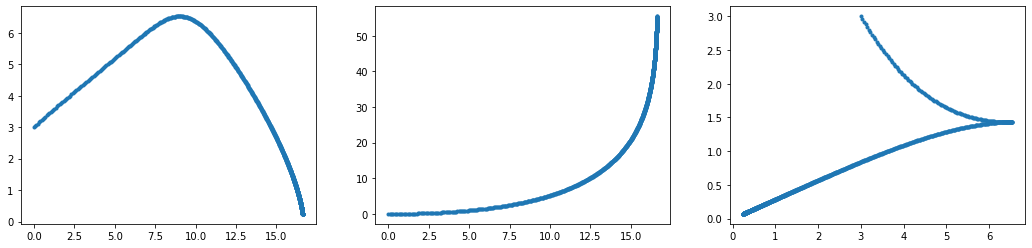

In [8]:
fig, ax = plt.subplots(1,3,figsize=(18,4))
ax[0].plot(sol_toggle_switch.y[0],sol_toggle_switch.y[2],'.');
ax[1].plot(sol_toggle_switch.y[0],sol_toggle_switch.y[1],'.');
ax[2].plot(sol_toggle_switch.y[2],sol_toggle_switch.y[3],'.');
"""
ax[0].plot(sol_piecewise.y[0],sol_piecewise.y[2],'.');
ax[1].plot(sol_piecewise.y[0],sol_piecewise.y[1],'.');
ax[2].plot(sol_piecewise.y[2],sol_piecewise.y[3],'.');
"""

In [ ]:
X=np.zeros((n,2,2))
X[:,0,:] = np.random.poisson(sol_toggle_switch.y[0:2,:].T)
X[:,1,:] = np.random.poisson(sol_toggle_switch.y[2:,:].T)

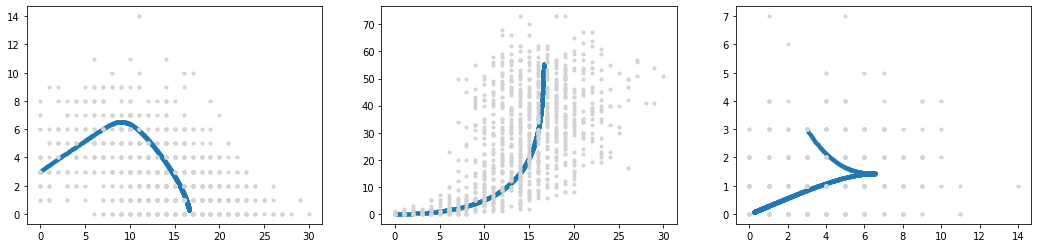

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(18,4))
ax[0].plot(sol_toggle_switch.y[0],sol_toggle_switch.y[2],'.');
ax[1].plot(sol_toggle_switch.y[0],sol_toggle_switch.y[1],'.');
ax[2].plot(sol_toggle_switch.y[2],sol_toggle_switch.y[3],'.');

ax[0].plot(X[:,0,0],X[:,1,0],'.',color='lightgray');
ax[1].plot(X[:,0,0],X[:,0,1],'.',color='lightgray');
ax[2].plot(X[:,1,0],X[:,1,1],'.',color='lightgray');

In [ ]:
Y=np.zeros((n,2,2))
Y_=np.zeros((n,2,2))
Y[:,0,:] = sol_toggle_switch.y[0:2,:].T
Y[:,1,:] = sol_toggle_switch.y[2:,:].T
Y_[:,0,:] = sol_piecewise.y[0:2,:].T
Y_[:,1,:] = sol_piecewise.y[2:,:].T

In [ ]:
logL = np.sum(X*np.log(Y+1e-6)-Y)

In [ ]:
logL_ = np.sum(X*np.log(Y_+1e-6)-Y_)

In [ ]:
logL, logL_

(19345.1814616582, 13911.119512963363)

In [ ]:
for seed in range(10):
  np.random.seed(seed)
  X=np.zeros((n,2,2))
  X[:,0,:] = np.random.poisson(sol_toggle_switch.y[0:2,:].T)
  X[:,1,:] = np.random.poisson(sol_toggle_switch.y[2:,:].T)
  logL = np.sum(X*np.log(Y+1e-6)-Y)
  logL_ = np.sum(X*np.log(Y_+1e-6)-Y_)
  print(logL, logL-logL_)


18880.03571626807 5324.7042063090485
19724.00254796687 5387.765836425984
19336.116476591138 5456.129096193097
19305.694539013144 5396.7025164842125
19103.44532761584 5333.563512339071
20141.930441571225 5433.368832422024
19846.408754534918 5228.998521898915
19225.844159742093 5459.7499646718425
19235.319949735633 5410.745083105829
19578.211082575617 5464.637577697415


## Fit toggle switch with piecewise

In [68]:
weight=np.diag(v=[1]*n)
tau = (0,0.5,1)
penalty=0
theta_hat = update_theta(X,weight,tau,penalty,alternative=False,parallel=True,n_threads=2,theta0=None, bnd=1000)

In [69]:
t=np.linspace(0,1,n)
Y_fit = get_Y(theta_hat,t,tau)

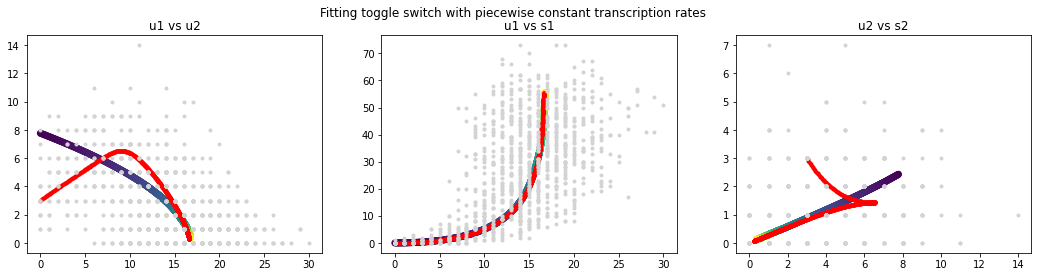

In [70]:
fig, ax = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("Fitting toggle switch with piecewise constant transcription rates")

ax[0].plot(sol_toggle_switch.y[0],sol_toggle_switch.y[2],'r.');
ax[0].set_title("u1 vs u2")
ax[1].plot(sol_toggle_switch.y[0],sol_toggle_switch.y[1],'r.');
ax[1].set_title("u1 vs s1")
ax[2].plot(sol_toggle_switch.y[2],sol_toggle_switch.y[3],'r.');
ax[2].set_title("u2 vs s2")

ax[0].plot(X[:,0,0],X[:,1,0],'.',color='lightgray');
ax[1].plot(X[:,0,0],X[:,0,1],'.',color='lightgray');
ax[2].plot(X[:,1,0],X[:,1,1],'.',color='lightgray');

ax[0].scatter(Y_fit[:,0,0],Y_fit[:,1,0],c=t);
ax[1].scatter(Y_fit[:,0,0],Y_fit[:,0,1],c=t);
ax[2].scatter(Y_fit[:,1,0],Y_fit[:,1,1],c=t);

In [71]:
theta_hat

array([[16.52106173, 16.83319367,  0.        ,  0.        ,  5.82877743,
         0.93046774],
       [ 0.18237896,  0.        ,  7.77194007,  2.43075787,  3.11594158,
        13.72520698]])

# Nothing out of nothing

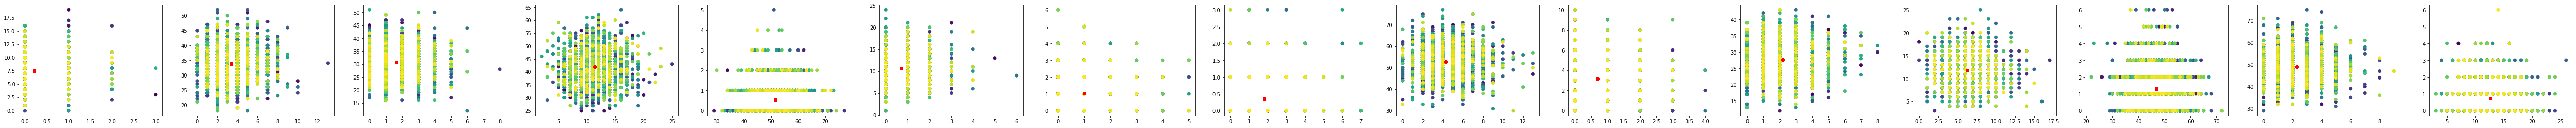

In [12]:
#%% generate data
np.random.seed(84)
n = 1500
p = 15
Tau=[0,0.5]
tau=(0,0.5,1)
K=len(tau)-1
t=np.linspace(0, 1, n)

theta=np.zeros((p,K+4))
loga_max=4
logb_max=2
theta[:,0]=np.exp(np.random.uniform(0,loga_max,size=p))-1
theta[:,1]=theta[:,0]
theta[:,-4]=theta[:,0]
theta[:,-3]=np.exp(np.random.uniform(0,loga_max,size=p))-1
theta[:,-2]=1
theta[:,-1]=theta[:,-4]/theta[:,-3]

Y = get_Y(theta,t,tau)

X = np.random.poisson(Y)

fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for i in range(p):
    ax[i].scatter(X[:,i,0],X[:,i,1],c=t);
    ax[i].scatter(Y[:,i,0],Y[:,i,1],c='r');

In [14]:
weight=np.diag(v=[1]*n)
tau = (0,0.5,1)
penalty=0
theta_hat = update_theta(X,weight,tau,penalty,alternative=False,parallel=True,n_threads=2,theta0=None, bnd=1000)

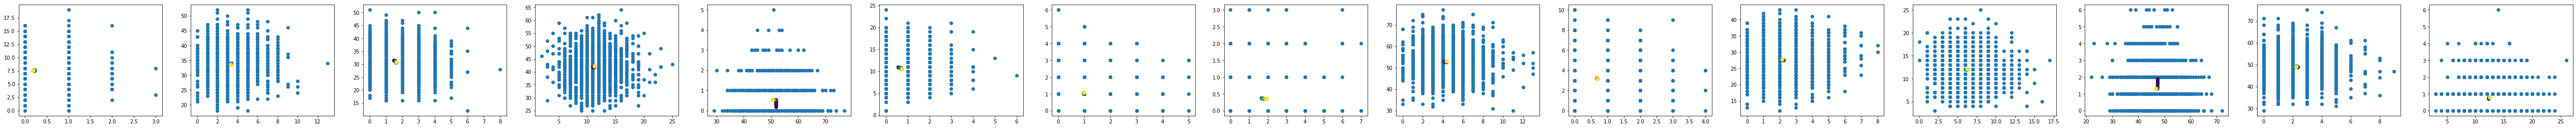

In [19]:
t=np.linspace(0,1,n)
Y_fit = get_Y(theta_hat,t,tau)

fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for i in range(p):
    ax[i].scatter(X[:,i,0],X[:,i,1]);
    ax[i].scatter(Y_fit[:,i,0],Y_fit[:,i,1],c=t);

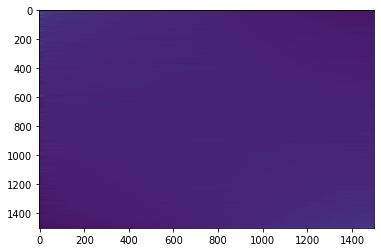

In [23]:
new_weight = update_weight(X,theta_hat,tau,n)
plot_t(new_weight)

In [ ]:
weight=np.diag(v=[1]*n)
tau = (0,0.5,1)
penalty=n*0.001
theta_hat = update_theta(X,weight,tau,penalty,alternative=False,parallel=True,n_threads=2,theta0=None, bnd=1000)

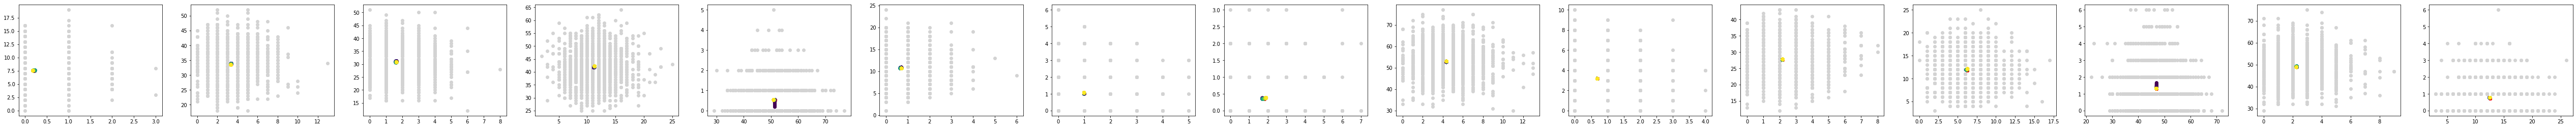

In [31]:
t=np.linspace(0,1,n)
Y_fit = get_Y(theta_hat,t,tau)

fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for i in range(p):
    ax[i].scatter(X[:,i,0],X[:,i,1],c='lightgray');
    ax[i].scatter(Y[:,i,0],Y[:,i,1],c='r');
    ax[i].scatter(Y_fit[:,i,0],Y_fit[:,i,1],c=t);

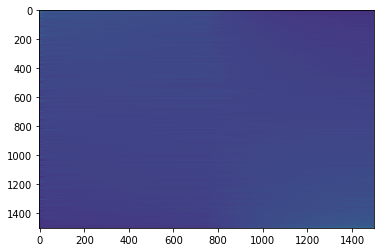

In [29]:
new_weight = update_weight(X,theta_hat,tau,n)
plot_t(new_weight)